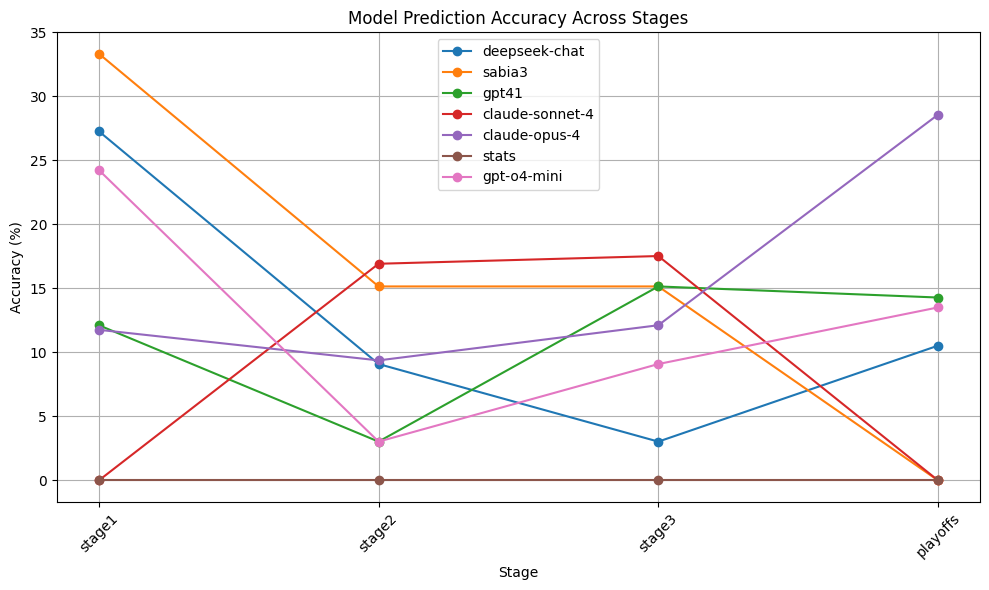

In [ ]:
import os
import json
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
from pathlib import Path

# Get the results directory (parent of current script location)
RESULTS_DIR = Path(__file__).parent.parent
ANALYSIS_DIR = Path(__file__).parent

def load_matches_from_folder(folder_path: str) -> List[Tuple[str, str, str]]:
    """Load all matches from a matches-cached folder."""
    matches = []
    matches_path = Path(folder_path) / 'matches-cached'
    if not matches_path.exists():
        return matches
        
    for filename in matches_path.iterdir():
        if filename.suffix == '.json':
            with open(filename) as f:
                match_data = json.load(f)
                matches.append((
                    match_data['winningTeam'],
                    match_data['losingTeam'],
                    filename.name
                ))
    return matches

def analyze_model_predictions(real_world_path: str, model_path: str, stage: str) -> Dict:
    """Compare model predictions with real world results for a given stage."""
    real_matches = load_matches_from_folder(real_world_path / stage)
    model_matches = load_matches_from_folder(model_path / stage)
    
    if not real_matches or not model_matches:
        return {
            'correct': 0,
            'total': 0,
            'accuracy': 0,
            'correct_matches': [],
            'wrong_matches': []
        }

    correct = 0
    correct_matches = []
    wrong_matches = []
    
    # Create dictionary of real matches for easy lookup
    real_results = {}
    for winner, loser, filename in real_matches:
        match_key = f"{winner}-{loser}"
        alt_key = f"{loser}-{winner}"
        real_results[match_key] = winner
        real_results[alt_key] = winner

    # Compare model predictions
    for winner, loser, filename in model_matches:
        match_key = f"{winner}-{loser}"
        alt_key = f"{loser}-{winner}"
        
        if match_key in real_results:
            real_winner = real_results[match_key]
            if real_winner == winner:
                correct += 1
                correct_matches.append(f"{winner} vs {loser}")
            else:
                wrong_matches.append(f"{winner} vs {loser} (actual: {real_winner})")
        elif alt_key in real_results:
            real_winner = real_results[alt_key]
            if real_winner == winner:
                correct += 1
                correct_matches.append(f"{winner} vs {loser}")
            else:
                wrong_matches.append(f"{winner} vs {loser} (actual: {real_winner})")

    total = len(model_matches)
    accuracy = (correct / total * 100) if total > 0 else 0

    return {
        'correct': correct,
        'total': total,
        'accuracy': accuracy,
        'correct_matches': correct_matches,
        'wrong_matches': wrong_matches
    }

def generate_analysis():
    stages = ['stage1', 'stage2', 'stage3', 'playoffs']
    models = [d for d in RESULTS_DIR.iterdir() if d.is_dir() and d.name != '0real-world' and not d.name.startswith('.')]
    
    # Store results for plotting
    plot_data = {model.name: [] for model in models}
    
    analysis_file = ANALYSIS_DIR / 'analysis.md'
    with open(analysis_file, 'w') as f:
        f.write("# CS2 Match Prediction Analysis\n\n")
        
        for model in models:
            f.write(f"## {model.name}\n\n")
            
            for stage in stages:
                results = analyze_model_predictions(
                    RESULTS_DIR / '0real-world',
                    model,
                    stage
                )
                plot_data[model.name].append(results['accuracy'])
                
                f.write(f"### {stage}\n")
                f.write(f"Accuracy: {results['accuracy']:.2f}% ({results['correct']}/{results['total']} matches)\n\n")
                
                if results['correct_matches']:
                    f.write("Correct Predictions:\n")
                    for match in results['correct_matches']:
                        f.write(f"- {match}\n")
                    f.write("\n")
                
                if results['wrong_matches']:
                    f.write("Wrong Predictions:\n")
                    for match in results['wrong_matches']:
                        f.write(f"- {match}\n")
                    f.write("\n")
            
            f.write("---\n\n")

    # Create plot
    plt.figure(figsize=(10, 6))
    for model_name, accuracies in plot_data.items():
        plt.plot(stages, accuracies, marker='o', label=model_name)
    
    plt.title('Model Prediction Accuracy Across Stages')
    plt.xlabel('Stage')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(ANALYSIS_DIR / 'accuracy-plot-per-match.png')

if __name__ == "__main__":
    generate_analysis()